In [12]:
# Cell 2: imports & load
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Paths
nb_dir = os.path.dirname(os.path.abspath("__file__"))
candidates = [
    os.path.join("notebooks", "features_with_rewards.csv"),
    os.path.join("notebooks", "features_agg.csv"),
    os.path.join(".", "features_with_rewards.csv"),
    os.path.join(".", "features_agg.csv"),
]

df = None
for p in candidates:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print("Loaded:", p)
        break

if df is None:
    raise FileNotFoundError("No features CSV found. Put features_with_rewards.csv or features_agg.csv in notebooks/")

print("Shape:", df.shape)
df.head()


Loaded: ./features_agg.csv
Shape: (1015, 9)


,session_id,src_ip,start,end,duration,cmd_count,unique_cmds,downloads,reward
0,68f4d3a2fd47e0aa10c84117,1.2.3.4,NaN,NaN,0,0,0,0,0.0
1,68f4dcdd1f21559d39a3732f,1.2.3.4,NaN,NaN,0,0,0,0,0.0
2,68f607bbb10cf72b09c6787d,1.2.3.4,NaN,NaN,0,0,0,0,0.0
3,68f720ab2c0f081e0b60fb58,1.2.3.4,NaN,NaN,0,0,0,0,0.0
4,68f8c5e2f6603c4190887d16,1.2.3.4,NaN,NaN,0,0,0,0,0.0


In [13]:
# Cell 3: sanity checks
print("Columns:", df.columns.tolist())
print("\nNumeric summary (first 10):")
display(df.select_dtypes(include=[np.number]).describe().T.head(10))
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Columns: ['session_id', 'src_ip', 'start', 'end', 'duration', 'cmd_count', 'unique_cmds', 'downloads', 'reward']

Numeric summary (first 10):


,count,mean,std,min,25%,50%,75%,max
start,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,1015.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
cmd_count,1015.0,2.940887,2.462030,0.0,0.0,5.0,5.0,5.0
unique_cmds,1015.0,0.588177,0.492406,0.0,0.0,1.0,1.0,1.0
downloads,1015.0,1.630542,2.345093,0.0,0.0,0.0,5.0,5.0
reward,1015.0,0.235271,0.196962,0.0,0.0,0.4,0.4,0.4



Missing values per column:
start          1015
end            1015
session_id        0
src_ip            0
duration          0
cmd_count         0
unique_cmds       0
downloads         0
reward            0
dtype: int64


In [14]:
# Cell 4: create label (pseudo) and select features
# If you have a real label column, set LABEL_COLUMN to it.
LABEL_COLUMN = None  # e.g. "label" if you have it

# If no ground truth label, create binary label from reward:
if LABEL_COLUMN and LABEL_COLUMN in df.columns:
    df['label'] = df[LABEL_COLUMN]
else:
    if 'reward' not in df.columns:
        # create reward from duration & cmd_count if not present
        if 'duration' in df.columns and 'cmd_count' in df.columns:
            df['duration_norm'] = (df['duration'] - df['duration'].min()) / ((df['duration'].max() - df['duration'].min()) or 1)
            df['cmd_count_norm'] = (df['cmd_count'] - df['cmd_count'].min()) / ((df['cmd_count'].max() - df['cmd_count'].min()) or 1)
            df['reward'] = 0.6 * df['duration_norm'] + 0.4 * df['cmd_count_norm']
        else:
            raise ValueError("No reward and no duration/cmd_count to synthesize it from.")
    # binary label: reward above median => 'engaged' attacker (1), else 0
    threshold = df['reward'].quantile(0.75)  # use top quartile as positive class; change as needed
    df['label'] = (df['reward'] >= threshold).astype(int)
    print(f"Pseudo-label created from reward; positive class = reward >= {threshold:.4f}")

# Prepare X, y
# drop non-feature columns (ids, timestamps, text fields). Adjust as needed.
drop_cols = []
for c in df.columns:
    if c.lower() in ('session_id','session','start','end','src_ip','label'):
        drop_cols.append(c)
    # drop raw events or long text columns if present
    if df[c].dtype == object and c not in ('label',):
        drop_cols.append(c)

X = df.drop(columns=drop_cols + ['label'], errors='ignore')
y = df['label'].astype(int)

print("X shape:", X.shape, "y distribution:\n", y.value_counts(normalize=True))


Pseudo-label created from reward; positive class = reward >= 0.4000
X shape: (1015, 5) y distribution:
 label
1    0.588177
0    0.411823
Name: proportion, dtype: float64


In [15]:
# Cell 5: preprocess
# Simple handling: fill NaNs with column mean and standardize numeric features
X_num = X.select_dtypes(include=[np.number]).copy()
X_num = X_num.fillna(X_num.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Save column names for later
feature_names = X_num.columns.tolist()


In [16]:
# Cell 6: train/test
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (812, 5) Test: (203, 5)


LogReg results: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}


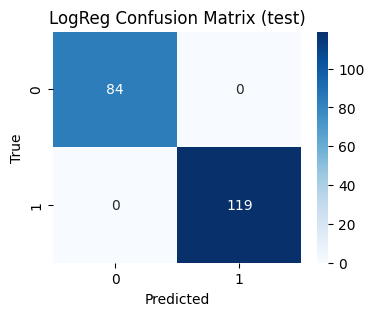

In [17]:
# Cell 7: Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1] if hasattr(lr, "predict_proba") else None

def metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba) if (y_proba is not None and len(np.unique(y_true))==2) else np.nan
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)

res_lr = metrics(y_test, y_pred_lr, y_proba_lr)
print("LogReg results:", res_lr)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LogReg Confusion Matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


RandomForest results: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}


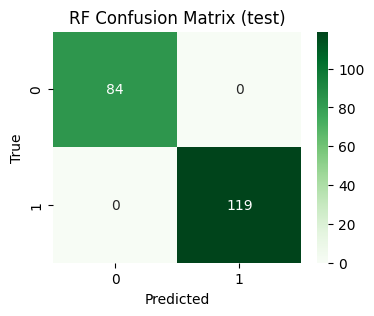

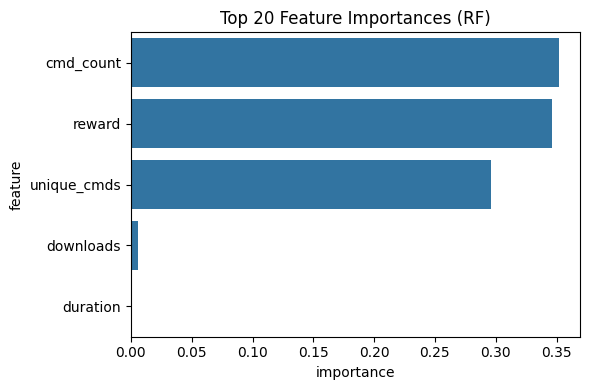

In [18]:
# Cell 8: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1] if hasattr(rf, "predict_proba") else None

res_rf = metrics(y_test, y_pred_rf, y_proba_rf)
print("RandomForest results:", res_rf)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("RF Confusion Matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# feature importances (top 20)
importances = rf.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(20)
plt.figure(figsize=(6,4))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Top 20 Feature Importances (RF)")
plt.tight_layout()
plt.show()


In [21]:
# Cell 9: cross-val & results summary
from sklearn.model_selection import cross_val_score

def cv_score(model, X, y, cv=5):
    return cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)

cv_lr = cv_score(lr, X_scaled, y, cv=5)
cv_rf = cv_score(rf, X_scaled, y, cv=5)

summary = pd.DataFrame([
    {"model":"LogisticRegression", **res_lr, "cv_f1_mean": cv_lr.mean(), "cv_f1_std": cv_lr.std()},
    {"model":"RandomForest", **res_rf, "cv_f1_mean": cv_rf.mean(), "cv_f1_std": cv_rf.std()},
])

print(summary)
out_path = os.path.join("week4_baseline_results.csv")
summary.to_csv(out_path, index=False)
print("Saved metrics to", out_path)


                model  accuracy  precision  recall   f1  roc_auc  cv_f1_mean  \
0  LogisticRegression       1.0        1.0     1.0  1.0      1.0         1.0   
1        RandomForest       1.0        1.0     1.0  1.0      1.0         1.0   

   cv_f1_std  
0        0.0  
1        0.0  
Saved metrics to week4_baseline_results.csv


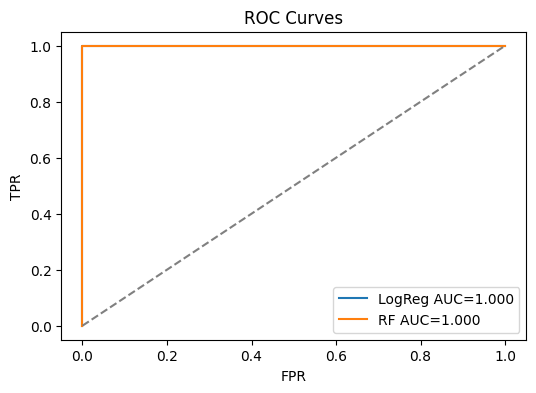

Notebook complete. Next: run `notebooks/week4_clusters.ipynb` for unsupervised clustering.


In [22]:
# Cell 10: ROC curve (if binary)
if y_proba_lr is not None and len(np.unique(y))==2:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

    plt.figure(figsize=(6,4))
    plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC={res_lr['roc_auc']:.3f}")
    plt.plot(fpr_rf, tpr_rf, label=f"RF AUC={res_rf['roc_auc']:.3f}")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves")
    plt.legend()
    plt.show()
else:
    print("ROC curve not plotted (need binary labels and probability outputs).")

print("Notebook complete. Next: run `notebooks/week4_clusters.ipynb` for unsupervised clustering.")
